In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from openbb import obb
obb.user.preferences.output_type = "dataframe"

## Get daily price data

In [2]:
# Date range carefully chosen so that both the first
# and last days are options expiration days
spy = obb.equity.price.historical(
    "SPY", 
    start_date="2011-12-16", 
    end_date="2024-03-15", 
    provider="yfinance"
)

In [3]:
spy

,open,high,low,close,volume,split_ratio,dividend,capital_gains
date,,,,,,,,
2011-12-16,122.230003,122.949997,121.300003,121.589996,220481400,0.0,0.770,0.0
2011-12-19,122.059998,122.320000,120.029999,120.290001,183903000,0.0,0.000,0.0
2011-12-20,122.180000,124.139999,120.370003,123.930000,225418100,0.0,0.000,0.0
2011-12-21,123.930000,124.360001,122.750000,124.169998,194230900,0.0,0.000,0.0
2011-12-22,124.629997,125.400002,124.230003,125.269997,119465400,0.0,0.000,0.0
...,...,...,...,...,...,...,...,...
2024-03-11,510.480011,511.880005,508.500000,511.279999,62557200,0.0,0.000,0.0
2024-03-12,513.450012,517.380005,510.859985,516.780029,73114400,0.0,0.000,0.0
2024-03-13,517.109985,517.289978,514.489990,515.969971,55104100,0.0,0.000,0.0


### Add calculated series: 1-day log return and day of week

In [4]:
spy.index = pd.to_datetime(spy.index).tz_localize("US/Eastern")

In [5]:
# compute log returns
spy["log_return"] = spy['close'].apply(np.log).diff(1)
# add a column with the day of the week
spy["day_of_week"] = spy.index.dayofweek

### Identify options expiration days

In [6]:
spy['opex_day'] = (spy.index.dayofweek == 4) & (spy.index.day >= 15) & (spy.index.day <= 21)

In [8]:
# In years in which Good Friday was the 3rd Friday
# (and hence the market was closed), designate the day before
# Good Friday as opex_day.
spy.at['2014-04-17', 'opex_day'] = True
spy.at['2019-04-18', 'opex_day'] = True
spy.at['2022-04-14', 'opex_day'] = True

### Identify the number of trading days before and after options expiration

In [9]:
spy['days_after_opex'] = spy.groupby(spy['opex_day'].eq(True).cumsum()).cumcount()

In [10]:
desc = spy.sort_index(ascending=False)

In [11]:
desc['days_before_opex'] = desc.groupby(desc['opex_day'].eq(True).cumsum()).cumcount()

In [12]:
desc

,open,high,low,close,volume,split_ratio,dividend,capital_gains,log_return,day_of_week,opex_day,days_after_opex,days_before_opex
date,,,,,,,,,,,,,
2024-03-15 00:00:00-04:00,510.209991,511.700012,508.119995,509.829987,107585800,0.0,1.595,0.0,-0.009993,4,True,0,0
2024-03-14 00:00:00-04:00,516.969971,517.130005,511.820007,514.950012,110171800,0.0,0.000,0.0,-0.001979,3,False,18,1
2024-03-13 00:00:00-04:00,517.109985,517.289978,514.489990,515.969971,55104100,0.0,0.000,0.0,-0.001569,2,False,17,2
2024-03-12 00:00:00-04:00,513.450012,517.380005,510.859985,516.780029,73114400,0.0,0.000,0.0,0.010700,1,False,16,3
2024-03-11 00:00:00-04:00,510.480011,511.880005,508.500000,511.279999,62557200,0.0,0.000,0.0,-0.000860,0,False,15,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-22 00:00:00-05:00,124.629997,125.400002,124.230003,125.269997,119465400,0.0,0.000,0.0,0.008820,3,False,4,18
2011-12-21 00:00:00-05:00,123.930000,124.360001,122.750000,124.169998,194230900,0.0,0.000,0.0,0.001935,2,False,3,19
2011-12-20 00:00:00-05:00,122.180000,124.139999,120.370003,123.930000,225418100,0.0,0.000,0.0,0.029811,1,False,2,20


In [13]:
spy['days_before_opex'] = desc['days_before_opex']

In [14]:
spy['before_or_after'] = np.where(
    (spy['days_before_opex'] < spy['days_after_opex']),
    - spy['days_before_opex'], spy['days_after_opex'])

In [15]:
spy

,open,high,low,close,volume,split_ratio,dividend,capital_gains,log_return,day_of_week,opex_day,days_after_opex,days_before_opex,before_or_after
date,,,,,,,,,,,,,,
2011-12-16 00:00:00-05:00,122.230003,122.949997,121.300003,121.589996,220481400,0.0,0.770,0.0,NaN,4,True,0,0,0
2011-12-19 00:00:00-05:00,122.059998,122.320000,120.029999,120.290001,183903000,0.0,0.000,0.0,-0.010749,0,False,1,21,1
2011-12-20 00:00:00-05:00,122.180000,124.139999,120.370003,123.930000,225418100,0.0,0.000,0.0,0.029811,1,False,2,20,2
2011-12-21 00:00:00-05:00,123.930000,124.360001,122.750000,124.169998,194230900,0.0,0.000,0.0,0.001935,2,False,3,19,3
2011-12-22 00:00:00-05:00,124.629997,125.400002,124.230003,125.269997,119465400,0.0,0.000,0.0,0.008820,3,False,4,18,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-11 00:00:00-04:00,510.480011,511.880005,508.500000,511.279999,62557200,0.0,0.000,0.0,-0.000860,0,False,15,4,-4
2024-03-12 00:00:00-04:00,513.450012,517.380005,510.859985,516.780029,73114400,0.0,0.000,0.0,0.010700,1,False,16,3,-3
2024-03-13 00:00:00-04:00,517.109985,517.289978,514.489990,515.969971,55104100,0.0,0.000,0.0,-0.001569,2,False,17,2,-2


In [16]:
spy['pop_avg_return'] = spy['log_return'].mean()
spy['relative_return'] = spy['log_return'] - spy['pop_avg_return']

In [17]:
spy[0:5]

,open,high,low,close,volume,split_ratio,dividend,capital_gains,log_return,day_of_week,opex_day,days_after_opex,days_before_opex,before_or_after,pop_avg_return,relative_return
date,,,,,,,,,,,,,,,,
2011-12-16 00:00:00-05:00,122.230003,122.949997,121.300003,121.589996,220481400,0.0,0.77,0.0,NaN,4,True,0,0,0,0.000466,NaN
2011-12-19 00:00:00-05:00,122.059998,122.320000,120.029999,120.290001,183903000,0.0,0.00,0.0,-0.010749,0,False,1,21,1,0.000466,-0.011215
2011-12-20 00:00:00-05:00,122.180000,124.139999,120.370003,123.930000,225418100,0.0,0.00,0.0,0.029811,1,False,2,20,2,0.000466,0.029346
2011-12-21 00:00:00-05:00,123.930000,124.360001,122.750000,124.169998,194230900,0.0,0.00,0.0,0.001935,2,False,3,19,3,0.000466,0.001469
2011-12-22 00:00:00-05:00,124.629997,125.400002,124.230003,125.269997,119465400,0.0,0.00,0.0,0.008820,3,False,4,18,4,0.000466,0.008354


In [18]:
opex_stats = spy['log_return'].groupby(spy['before_or_after']).describe()

In [19]:
opex_stats

,count,mean,std,min,25%,50%,75%,max
before_or_after,,,,,,,,
-12,16.0,0.005606,0.009679,-0.005594,-0.000348,0.003853,0.006536,0.029998
-11,46.0,0.000384,0.009338,-0.036190,-0.003005,0.000741,0.006229,0.020093
-10,51.0,0.001317,0.009099,-0.028290,-0.001703,0.001651,0.005618,0.025307
-9,138.0,-0.000800,0.011483,-0.081313,-0.003472,0.000598,0.004104,0.022673
-8,147.0,0.000067,0.010647,-0.027703,-0.005327,-0.000197,0.003888,0.065007
-7,147.0,0.000865,0.009750,-0.049977,-0.003275,0.001211,0.005594,0.026458
-6,147.0,0.000158,0.014284,-0.100569,-0.003178,0.000802,0.005973,0.053497
-5,147.0,0.001237,0.011274,-0.029424,-0.002886,0.001217,0.005440,0.082028
-4,147.0,0.000093,0.012878,-0.115887,-0.003184,0.000785,0.005540,0.025372


<Axes: xlabel='before_or_after'>

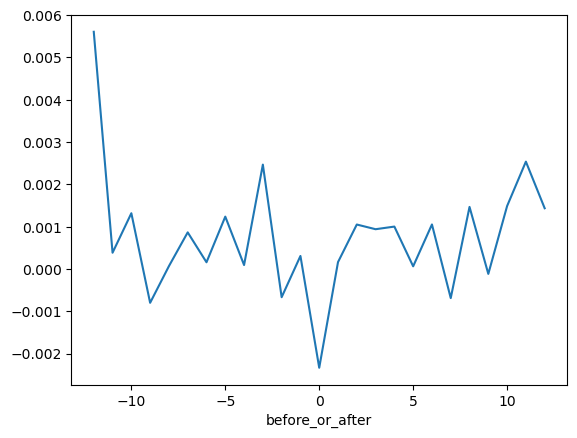

In [20]:
opex_stats['mean'].plot()

In [21]:
# Can I plot the above only from -9 to +9 days to reduce outliers that have fewer data points?

<Axes: xlabel='before_or_after'>

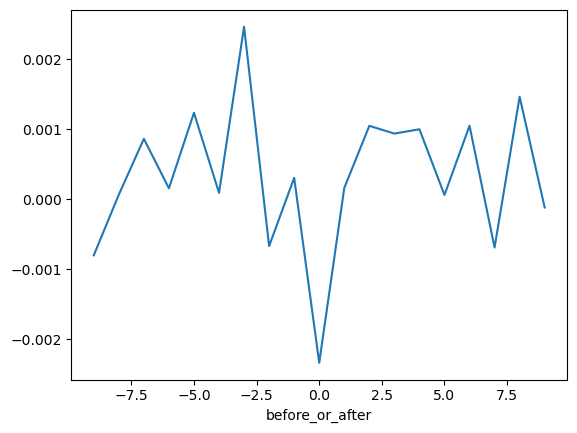

In [22]:
opex_stats.loc[-9:9, 'mean'].plot()

<Axes: xlabel='before_or_after'>

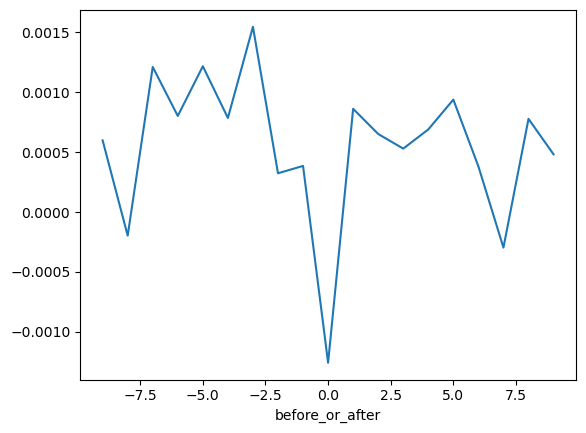

In [23]:
opex_stats.loc[-9:9, '50%'].plot()